In [0]:
#Importing Libraries
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
#Importing data
final_df = pd.read_csv('reddit_post_combined.csv')
final_df.drop(columns = ['Unnamed: 0'], inplace = True)
final_df.head()

,title,text,class
0,[REQ] $300 Loan until Oct 15 - will repay $330,I was doored by a taxi and was severely injure...,cc
1,[PAID] triniwarrior - $100 + interest,"Great transaction, no reminder needed!\n\nhttp...",cc
2,[PAID] BestDLine - $50 + interest,"Great transaction as always, no reminder neede...",cc
3,[PAID] bdubble $25 + Interest,http://www.reddit.com/r/Loans/comments/2fd6gg/...,cc
4,[REQ] I need £0.15/$0.26!,So recently I purchased something on eBay that...,cc


In [0]:
#Changing class as 0 for loan, 1 for Credit Card
final_df['class'] = final_df['class'].map({'cc': 1, 'ln': 0})
#Checking the baseline accuracy
final_df['class'].value_counts(normalize = True)

1    0.512706
0    0.487294
Name: class, dtype: float64

##Training three machine learning text Classification models to predict subreddit class



*   ***Logistic Regression Model***
*   ***Naive Bayes Model*** 
*   ***Neural Networks*** 




In [0]:
#Creating X and Y for the model
X = final_df['text']
y = final_df['class']

In [0]:
#Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

## Logistic Regression Model

In [0]:
#Creating a Pipleine of a count vectorizer and a logistic regression model
#Also incorporate stopwords for the count vectorizer
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words = stopwords.words("english"), max_features = 200, token_pattern=r'\b[^\d\W]+\b')),
    ('lr', LogisticRegression())
])

In [0]:
import warnings
warnings.filterwarnings("ignore")
# Evaluate how the model will perform on training data
print (f' The cross validation score on the training data is {cross_val_score(pipe, X_train, y_train, cv=3).mean()}') 

# Fit your model
pipe.fit(X_train, y_train)

# Evaluating how the model does on unseen Test data
print (f' The accuracy score on the testing data is {pipe.score(X_test, y_test)}')



 The cross validation score on the training data is 0.925101677681749
 The accuracy score on the testing data is 0.9376114081996435


In [0]:
#Gridsearching to fine tune parameters of the model
pipe_params = {
    'cvec__max_features': [600,800,900],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}
warnings.filterwarnings("ignore")
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train)
print(f' The accuracy score for the grid searched model on the training data is {np.round(gs.best_score_,3)*100}%')

 The accuracy score for the grid searched model on the training data is 95.19999999999999%


In [0]:

print(f' The accuracy score for the grid searched model on the testing data is {np.round(gs.score(X_test, y_test),5)*100}%')

 The accuracy score for the grid searched model on the testing data is 95.544%


##Naive Bayes Model

In [0]:
#Initialising & Fitting the count vectorizer
cvec = CountVectorizer(stop_words = stopwords.words("english"), max_features= 800, token_pattern=r'\b[^\d\W]+\b')
cvec.fit(X_train)

#Transforming the test and train data in cvec objects
X_train_naive = cvec.transform(X_train)
X_test_naive = cvec.transform(X_test)

# Convert X_train_naive into a DataFrame
X_train_df = pd.DataFrame(X_train_naive.toarray(),
                   columns=cvec.get_feature_names())

# Convert X_test_naive into a DataFrame
X_test_df = pd.DataFrame(X_test_naive.toarray(),
                   columns=cvec.get_feature_names())

In [0]:
#Checking the training data
X_train_df.head()

,able,abrubt,absolutely,ac,accept,access,account,accounts,across,active,actual,actually,add,added,additional,address,advance,advice,afford,afloat,afternoon,ago,ahead,almost,along,already,also,always,ambulance,amount,amounts,amp,another,anticipate,anyone,anything,apartment,apply,appreciate,appreciated,...,wa,wage,wait,waiting,wallet,want,wanted,warning,washington,way,website,week,weekend,weekly,weeks,well,went,west,western,whatever,wife,willing,wisconsin,within,without,women,wondering,wont,work,working,works,would,write,www,year,years,yesterday,yet,yourxmother,zero
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [0]:
#Checking the testing data
X_test_df.head()

,able,abrubt,absolutely,ac,accept,access,account,accounts,across,active,actual,actually,add,added,additional,address,advance,advice,afford,afloat,afternoon,ago,ahead,almost,along,already,also,always,ambulance,amount,amounts,amp,another,anticipate,anyone,anything,apartment,apply,appreciate,appreciated,...,wa,wage,wait,waiting,wallet,want,wanted,warning,washington,way,website,week,weekend,weekly,weeks,well,went,west,western,whatever,wife,willing,wisconsin,within,without,women,wondering,wont,work,working,works,would,write,www,year,years,yesterday,yet,yourxmother,zero
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
#instantiating & fitting the Gaussian Naive Bayes classifier
nb = GaussianNB()
nb.fit(X_train_df, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [0]:
#Generating predictions for the test data
pred1 = nb.predict(X_test_df)
pred_train = nb.predict(X_train_df)
print(f'The training accuracy score provided by the Naive Bayes Classifier was {np.round((accuracy_score(y_train, pred_train)*100),3)}%')

The training accuracy score provided by the Naive Bayes Classifier was 91.914%


In [0]:
print(f'The testing accuracy score provided by the Naive Bayes Classifier was {np.round((accuracy_score(y_test, pred1)*100),3)}%')

The testing accuracy score provided by the Naive Bayes Classifier was 93.048%


##Densely Connected Neural Network model

In [0]:
#Importing tensorflow and keras
import tensorflow as tf
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from tensorflow.python.data import Dataset
from tensorflow import keras

tf.logging.set_verbosity(tf.logging.ERROR)

In [0]:
# Designing the neural network model

model = keras.Sequential([
    keras.layers.Dense(64, activation = tf.nn.relu,
                      input_shape = (X_train_df.shape[1],)),
    keras.layers.Dense(64, activation = tf.nn.sigmoid),
    keras.layers.Dense(1)
])

In [0]:
#The loss is the mean square error and the metric used is the mean absolute error
optimizer = tf.train.AdamOptimizer()
model.compile(loss='binary_crossentropy',
             optimizer = optimizer,
             metrics = ['accuracy'])

model.summary()

#To check whether our model runs
class Dot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0 : print('')
    print ('.', end='')
    
set_epoch = 100
tf.set_random_seed(42)

# Store training stats
fitting = model.fit(X_train_df, y_train, epochs = set_epoch,
                   validation_split =0.2, verbose = 0,
                   callbacks=[Dot()])


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 64)                51264     
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 65        
Total params: 55,489
Trainable params: 55,489
Non-trainable params: 0
_________________________________________________________________

....................................................................................................

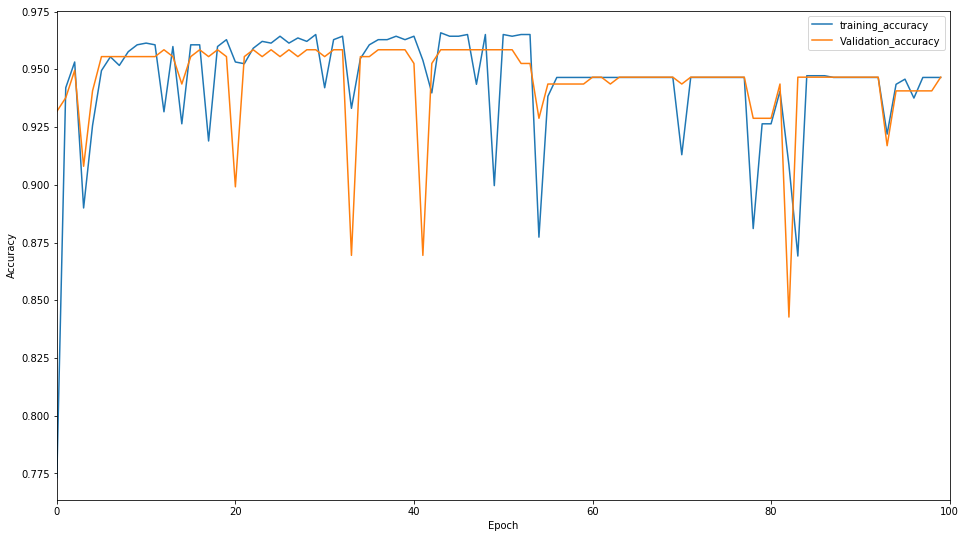

In [0]:
#Plottingthe model

import matplotlib.pyplot as plt
def plot_history(history):
  plt.figure(figsize = (16,9))
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(history.epoch, np.array(history.history['acc']), label = 'training_accuracy')
  plt.plot(history.epoch, np.array(history.history['val_acc']), label = 'Validation_accuracy')
  plt.legend()
  plt.xlim([0,100])
plot_history(fitting)

In [0]:
#Storing predictions of the neural network
pred_nn = model.predict_classes(X_test_df)
pred_test_nn = model.predict_classes(X_train_df)
#Accuracy of the Neural Network model
print(f'The training accuracy score provided by the Neural Network Model was {np.round(metrics.accuracy_score(y_train, pred_test_nn)*100,3)}%')
print(f'The testing accuracy score provided by the Neural Network Model was {np.round(metrics.accuracy_score(y_test, pred_nn)*100,3)}%')

The training accuracy score provided by the Neural Network Model was 94.649%
The testing accuracy score provided by the Neural Network Model was 93.226%


##Confusion Matrices for the models

In [0]:
## Confusion Matrix for Naive Bayes model
conf_nb = pd.DataFrame(confusion_matrix(y_test, pred1), index = ['Loan', 'Credit Card'], 
                    columns = ['Predicted Loan', 'Predicted Credit Card'])
conf_nb

,Predicted Loan,Predicted Credit Card
Loan,234,39
Credit Card,0,288


In [0]:
## Confusion Matrix for Neural Network model
conf_nn = pd.DataFrame(confusion_matrix(y_test, pred_nn), index = ['Loan', 'Credit Card'], 
                    columns = ['Predicted Loan', 'Predicted Credit Card'])
conf_nn

,Predicted Loan,Predicted Credit Card
Loan,254,19
Credit Card,19,269


In [0]:
#Predictions for the gridsearch model
pred = gs.predict(X_test)

## Confusion Matrix for Grid Searched Logistic Regression  model
conf_lr = pd.DataFrame(confusion_matrix(y_test, pred), index = ['Loan', 'Credit Card'], 
                    columns = ['Predicted Loan', 'Predicted Credit Card'])
conf_lr

,Predicted Loan,Predicted Credit Card
Loan,248,25
Credit Card,0,288


## Checking potential for fine tuning by checking the AUC (ROC)

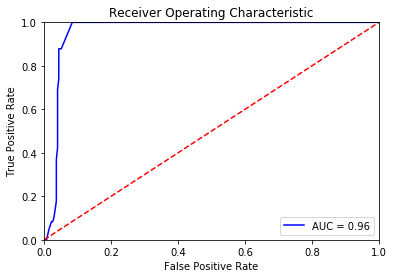

In [0]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = gs.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# Plotting the ROC curve
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()